In [1]:
from pathlib import Path
from glob import glob
import os
import tqdm
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from umap.umap_ import UMAP
import os
import numpy as np
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
import math

import pandas as pd
from umap.umap_ import UMAP
from plotly.subplots import make_subplots

from EmbeddingsConstruction.ConferencePipeline import ConferenceEmbeddingPipeline

# json_path="/home/aacastro/Alejandro/ACA_MultichanelAI_2025/2025_ACA_MultichannelAI/transcript_exemple.json"

base_path = Path("../conferences_data")

base_companies = base_path / "companies"
base_processed = base_path / "processed_companies"

json_paths = glob(f"{base_processed}/**/*.json", recursive=True)
# json_path = "/home/aacastro/mchai/processed_companies/KMI/2024/Q2/transcript.json"

/home/aacastro/env_general/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-08 18:06:27.064323: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-08 18:06:27.075861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749405987.089505   25680 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749405987.093348   25680 cuda_blas.cc:1407] Una

In [2]:
def extract_ticker_from_path(path):
    return os.path.normpath(path).split(os.sep)[-4]

def extract_conference_name_from_path(path):
    parts = os.path.normpath(path).split(os.sep)
    year = parts[-3]  # '2018'
    quarter = parts[-2].replace("transcript.json", "").replace("/", "").strip()
    return f"{year}_{quarter}"  # '2018_Q3'

In [3]:
pipeline = ConferenceEmbeddingPipeline(
    node_encoder_params={"hidden_dim": 128, "meta_dim": 32, "n_heads": 8, "d_output": 512,
                        "weights_path": "./EmbeddingsConstruction/weights/node_encoder_best.pt"},
    conference_encoder_params={"input_dim": 512, "hidden_dim": 256, "n_heads": 4, "d_output": 512,#},
                        "weights_path": "./EmbeddingsConstruction/weights/conference_encoder_best.pt"},
    device="cuda",
)
pipeline.node_encoder.eval()
pipeline.conference_encoder.eval()

✅ Pesos cargados desde: ./EmbeddingsConstruction/weights/node_encoder_best.pt
✅ Pesos cargados desde: ./EmbeddingsConstruction/weights/conference_encoder_best.pt


ConferenceEncoder(
  (pos_embedding): Embedding(1001, 512)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (proj): Linear(in_features=512, out_features=512, bias=True)
)

In [4]:
embeddings = []
tickers = []
conference_names = []


for path in tqdm(json_paths):
    try:
        embedding = pipeline.generate_embedding(path, return_attn=True).detach().cpu().numpy().flatten()
        embeddings.append(embedding)
        tickers.append(extract_ticker_from_path(path))
        conference_names.append(extract_conference_name_from_path(path))
    except Exception as e:
        print(f"❌ Error en {path}: {e}")

100%|██████████| 3407/3407 [01:30<00:00, 37.84it/s]


In [5]:
# conference_embedding = pipeline.generate_embedding(json_path, return_attn=True).detach().cpu().numpy()
# pipeline.visualize({
#     "tree_structure": False,
#     "plot": False,
#     "umap": False,
#     "silhouette":False,
#     "attention_tree": False
# })
# print("Embedding conferencia:", conference_embedding.shape)
# conference_embedding.flatten()

/home/aacastro/env_general/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_25680/1347525736.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


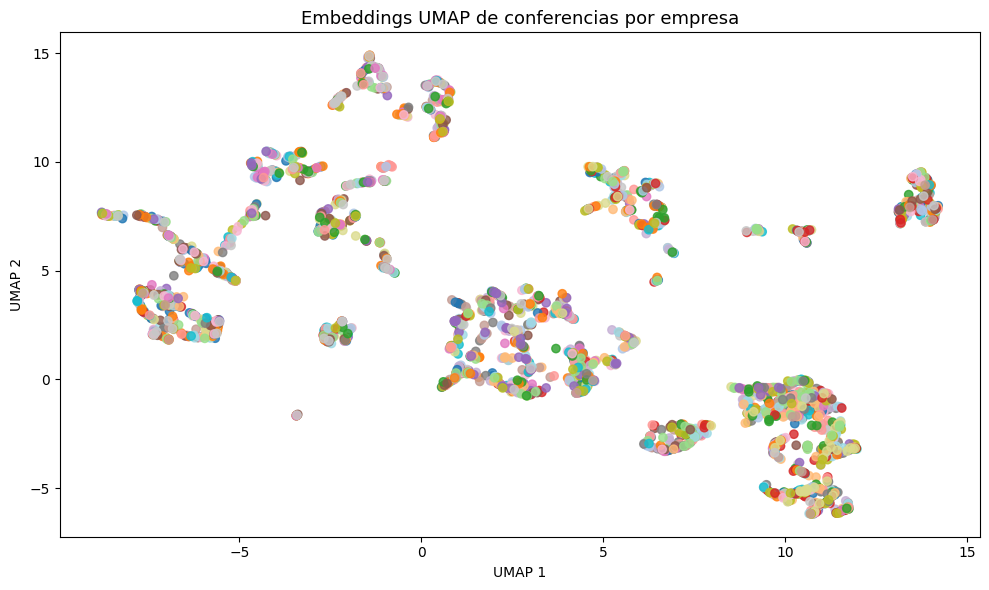

In [6]:
# UMAP
reducer = UMAP(n_neighbors=10, min_dist=0.1, metric='cosine')
embeddings_2d = reducer.fit_transform(np.vstack(embeddings))

# Colores
unique_tickers = sorted(set(tickers))
ticker_to_color = {ticker: i for i, ticker in enumerate(unique_tickers)}
colors = [ticker_to_color[t] for t in tickers]

# Visualización
plt.figure(figsize=(10, 6))
cmap = get_cmap('tab20')
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                      c=[ticker_to_color[t] for t in tickers],
                      cmap=cmap, alpha=0.8)

# Leyenda coherente
handles = [plt.Line2D([0], [0], marker='o', linestyle='',
                      color=cmap(ticker_to_color[t] / max(1, len(unique_tickers) - 1)),
                      label=t, markersize=8)
           for t in unique_tickers]

# plt.legend(handles=handles, title="Empresa", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Embeddings UMAP de conferencias por empresa", fontsize=13)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

In [7]:
import plotly.express as px
import pandas as pd
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Crear DataFrame con la información
df = pd.DataFrame({
    'UMAP_1': embeddings_2d[:, 0],
    'UMAP_2': embeddings_2d[:, 1],
    'Ticker': tickers,
    'Conference': conference_names,
    'Index': list(range(len(tickers)))
})

# Graficar con Plotly
fig = px.scatter(
    df,
    x="UMAP_1",
    y="UMAP_2",
    color="Ticker",
    hover_data={
        "Ticker": True,
        "Conference": True,
        "Index": True,
        "UMAP_1": ':.2f',
        "UMAP_2": ':.2f'
    },
    title="UMAP Embedding of conferences by company",
    width=1000,
    height=600,
)

fig.update_traces(marker=dict(size=7, opacity=0.8))
fig.update_layout(legend_title="Company", title_x=0.5)
fig.show()

In [8]:
metrics_to_plot = ['cosine', 'euclidean'] # Add more to show more graphics

In [9]:
# Preparación de datos
embeddings_array = np.vstack(embeddings)
tickers_array = np.array(tickers)
conference_names_array = np.array(conference_names)



n_cols = 2
n_rows = math.ceil(len(metrics_to_plot) / n_cols)

fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=[f"UMAP - {m}" for m in metrics_to_plot],
    horizontal_spacing=0.05, vertical_spacing=0.1
)

# Colores únicos por ticker
unique_tickers = sorted(set(tickers))
color_map = {t: i for i, t in enumerate(unique_tickers)}

for idx, metric in enumerate(metrics_to_plot):
    row = idx // n_cols + 1
    col = idx % n_cols + 1

    try:
        reducer = UMAP(n_neighbors=10, min_dist=0.1, metric=metric, random_state=42)
        projection = reducer.fit_transform(embeddings_array)

        for t in unique_tickers:
            indices = [i for i, x in enumerate(tickers_array) if x == t]
            fig.add_trace(
                go.Scatter(
                    x=projection[indices, 0],
                    y=projection[indices, 1],
                    mode='markers',
                    marker=dict(size=7),
                    name=t if idx == 0 else None,  # solo la primera métrica muestra la leyenda
                    hovertext=[f"{t} - {conference_names_array[i]}" for i in indices],
                    showlegend=(col == 1 and row == 1)  # leyenda solo en el primer subplot
                ),
                row=row,
                col=col
            )
    except Exception as e:
        fig.add_annotation(
            text=f"Error: {e}",
            xref="x domain", yref="y domain",
            x=0.5, y=0.5,
            showarrow=False,
            row=row, col=col
        )

fig.update_layout(
    height=400 * n_rows,
    width=1200,
    title_text="Comparación de proyecciones UMAP con distintas métricas",
    legend_title="Ticker",
    margin=dict(t=80, b=40)
)

fig.show()

/home/aacastro/env_general/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/aacastro/env_general/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/aacastro/env_general/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/aacastro/env_general/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [10]:
import json
import numpy as np

# Pon aquí las rutas a tus archivos JSON
path1 = "/home/aacastro/conferences_data/processed_companies/TSLA/2021/Q3/transcript.json"
path2 = "/home/aacastro/conferences_data/processed_companies/TSLA/2024/Q2/transcript.json"

def get_mean_audio_emb(data):
    embs = []
    for v in data['monologue_interventions'].values():
        audio = v['multimodal_embeddings']['audio']
        if isinstance(audio, list) and len(audio) > 0 and isinstance(audio[0], list):
            emb_arr = np.array(audio)
            mean_emb = emb_arr.mean(axis=0)
            embs.append(mean_emb)
    if embs:
        return np.stack(embs).mean(axis=0)
    else:
        return None

def cosine_sim(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

# Carga los archivos
with open(path1, "r") as f1, open(path2, "r") as f2:
    data1 = json.load(f1)
    data2 = json.load(f2)

mean_audio_1 = get_mean_audio_emb(data1)
mean_audio_2 = get_mean_audio_emb(data2)

if mean_audio_1 is None or mean_audio_2 is None:
    print("No se encontraron embeddings de audio en uno de los archivos.")
else:
    score = cosine_sim(mean_audio_1, mean_audio_2)
    print(f"Similitud coseno entre los medios de audio: {score:.4f}")


Similitud coseno entre los medios de audio: 0.9986
